<center><h1>YOLO Object Detector for Whale & Dolphin Images</h1></center>

# Introduction

🐠 Drived from various other notebooks, I've only set this up for Co-lab.  Maybe next time will add options for kaggle or running on my own GPU.  

[Great-Barrier-Reef: YOLOv5 train 🌊](https://www.kaggle.com/awsaf49/great-barrier-reef-yolov5-train), 

[Great-Barrier-Reef: YOLOv5 [infer] 🌊](https://www.kaggle.com/awsaf49/great-barrier-reef-yolov5-infer)

[official YOLOv5 user notebook on Kaggle by Ultralytics](https://www.kaggle.com/ultralytics/yolov5). Full tutorial on how to get started. 

[And this one putting them together by Andrada Oleanu](https://www.kaggle.com/andradaolteanu/greatbarrierreef-yolo-full-guide-train-infer)

[And this one also handy](https://blog.paperspace.com/train-yolov5-custom-data/)

🐠 **YOLO Explained**

1. The image is split in a grid that has the same dimension for each "tile".
2. We add the bounding boxes that identify each object. The bbox has the following format: `[width, height, class, bx, by]`, where `[bx, by]` represents the center of the object.
3. Intersection Over Union: this technique is used so the bounding box "catches" the object fully (and doesn't leave any part of it uncovered, neither it is too large for the object). The `IOU=1` if the predicted and actual box are identical.

<center><img src="https://i.imgur.com/Ce1sfqj.png" width=700></center>

*Source: [here](https://www.section.io/engineering-education/introduction-to-yolo-algorithm-for-object-detection/)*

### ⬇ Libraries and Dependencies Below

## II. YOLOv5 Setup

To use the model we need to have the following:
* Yolov5 Repository ([available in this dataset by Awsaf](https://www.kaggle.com/awsaf49/yolov5-lib-ds))
* Python 3
* PyTorch
* CUDA

In [ ]:
# Standard Libraries
import os
import sys
#import torch
import time
import random
import shutil
import yaml
from tqdm import tqdm
import warnings
import cv2
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from IPython.display import display_html
from pathlib import Path

#Check for the environment
IN_COLAB = 'google.colab' in sys.modules  #Checking if this is running in Colab
IN_KAGGLE = os.environ.get('PWD') == '/kaggle/working'

if (IN_COLAB):
  root = Path(os.getcwd())
  project_folder = root / 'drive/My Drive/Colab Notebooks/Kaggle/Happy_Whale'
  data_folder = project_folder / 'yolo_data'
  image_folder = data_folder / 'images'
  print("Running on Colab")
  print('The project folder is:', project_folder)

  gpu_info = !nvidia-smi    
  gpu_info = '\n'.join(gpu_info)
  if gpu_info.find('failed') >= 0:
    print('Not connected to a GPU')
  else:
    print(gpu_info)

  from psutil import virtual_memory
  ram_gb = virtual_memory().total / 1e9
  print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

  if ram_gb < 20:
    print('Not using a high-RAM runtime')
  else:
    print('You are using a high-RAM runtime!')


#if IN_KAGGLE:
#    print("We are running on a Kaggle Server")

#if not IN_COLAB or IN_KAGGLE:   
#    IN_OTHER = True
#    print("Running on a machine with personalised directory structures")

Running on Colab
The project folder is: /content/drive/My Drive/Colab Notebooks/Kaggle/Happy_Whale
Not connected to a GPU
Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


In [ ]:
if IN_COLAB:
  from google.colab import drive
  pro_dir = Path('drive/My Drive/Colab Notebooks/') / project_folder
  if not os.path.isdir(project_folder):    # Just checking if mounted already
    drive.mount('/content/drive')   

# if IN_OTHER:
#   PRO_DIR = Path(os.path.realpath('__file__')) # For working on a local machine 

print('Initial Working directory: ', os.getcwd()) # Reference subdirectories  PRO_DIR / <MY_DIR_NAME>
os.chdir(project_folder / 'yolov5')
print("Current working directory: {0}".format(os.getcwd()))

Initial Working directory:  /content
Current working directory: /content/drive/My Drive/Colab Notebooks/Kaggle/Happy_Whale/yolov5


In [ ]:
# install YOLO dependencies as necessary
%pip install -qr requirements.txt  
import torch
from IPython.display import Image, clear_output  # to display images
#from utils.google_utils import gdrive_download  # to download models/datasets

#from yolov5 import utils
#display = utils.notebook_init()  # I presume this is a kaggle thing

# clear_output()
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

Setup complete. Using torch 1.10.0+cu111 CPU


In [ ]:
#Dependencies and setup
if IN_COLAB:
  !pip install wandb -qqq

import wandb

# Log in to your W&B account
wandb.login()

wandb: Currently logged in as: wologman (use `wandb login --relogin` to force relogin)


True

Current Working Directory /content/drive/MyDrive/Colab Notebooks/Kaggle/Happy_Whale/yolov5
Notebook Color Scheme:


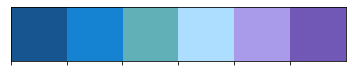

In [ ]:
# Environment check
warnings.filterwarnings("ignore")
os.environ["WANDB_SILENT"] = "true"
CONFIG = {'competition': 'greatReef', '_wandb_kernel': 'aot'}

# 🐝 Secrets  (Kaggle only)
#from kaggle_secrets import UserSecretsClient
#user_secrets = UserSecretsClient()
#secret_value_0 = user_secrets.get_secret("wandb")
#! wandb login $secret_value_0

# Custom colors     color class used here is ANSI escape code coloring, for coloring in terminal windows.  
class color:
    S = '\033[1m' + '\033[94m'
    E = '\033[0m'
    
my_colors = ["#16558F", "#1583D2", "#61B0B7", "#ADDEFF", "#A99AEA", "#7158B7"]
print(color.S+"Current Working Directory"+color.E, os.getcwd())
print(color.S+"Notebook Color Scheme:"+color.E)
sns.palplot(sns.color_palette(my_colors))

### ⬇ Helper Functions Below

In [ ]:
# === 🐝 W&B ===
def save_dataset_artifact(run_name, artifact_name, path):
    '''Saves dataset to W&B Artifactory.
    run_name: name of the experiment
    artifact_name: under what name should the dataset be stored
    path: path to the dataset'''
    
    run = wandb.init(project='g2net', 
                     name=run_name, 
                     config=CONFIG, anonymous="allow")
    artifact = wandb.Artifact(name=artifact_name, 
                              type='dataset')
    artifact.add_file(path)

    wandb.log_artifact(artifact)
    wandb.finish()
    print("Artifact has been saved successfully.")
    
    
def create_wandb_plot(x_data=None, y_data=None, x_name=None, y_name=None, title=None, log=None, plot="line"):
    '''Create and save lineplot/barplot in W&B Environment.
    x_data & y_data: Pandas Series containing x & y data
    x_name & y_name: strings containing axis names
    title: title of the graph
    log: string containing name of log'''
    
    data = [[label, val] for (label, val) in zip(x_data, y_data)]
    table = wandb.Table(data=data, columns = [x_name, y_name])
    
    if plot == "line":
        wandb.log({log : wandb.plot.line(table, x_name, y_name, title=title)})
    elif plot == "bar":
        wandb.log({log : wandb.plot.bar(table, x_name, y_name, title=title)})
    elif plot == "scatter":
        wandb.log({log : wandb.plot.scatter(table, x_name, y_name, title=title)})
        
        
def create_wandb_hist(x_data=None, x_name=None, title=None, log=None):
    '''Create and save histogram in W&B Environment.
    x_data: Pandas Series containing x values
    x_name: strings containing axis name
    title: title of the graph
    log: string containing name of log'''
    
    data = [[x] for x in x_data]
    table = wandb.Table(data=data, columns=[x_name])
    wandb.log({log : wandb.plot.histogram(table, x_name, title=title)})

# Set up File structure for Colab.

In Kaggle by default the working directory is `/kaggle/working`. Whenever you want to `save` a file, the output goes there.

The default working directory in Colab is `/content`. But this is a pain because the data gets lost at the end of the session.  So I'm trying to work from a project directory within g-drive, and include the yolov5 repo in there. So in this case `/content/drive/My Drive/Colab Notebooks/Kaggle/Happy_Whale/` 


🐠 The idea here is to create 2 more folders: 
* `/<projec directory>/data/images` - folder where we will store training images, with 3 sub-folders train, val and test.
* `/<projec directory>/data/labels` - folder where we will store labels (annotations) found within these images, with 3 sub-folders.

## II. The Labels

In this case I've created the annotations in CVAT, and exported in YOLO 1.1 format. It may also be handy sometimes to use the COCO format, so I leave this converter here for future projects. Also it's handy to do the reverse to display with openCV & Pillow.

For COCO to YOLO, we need to go from `[xmin, ymin, w, h]` to the corresponding yolo format `[xmid, ymid, w, h]`.

<center><img src="https://i0.wp.com/prabhjotkaurgosal.com/wp-content/uploads/2021/03/image.png?resize=1536%2C419&ssl=1" width=900></center>

*Source: [here](https://prabhjotkaurgosal.com/weekly-learnings/weekly-learning-blogs/)*

### Annotation

🐠  In the YOLO labeling format, a `.txt` file with the same name is created for each image file in the same directory. Each `.txt` file contains the annotations for the corresponding image file, that is:
* *object class* - not applicable in our case, so it will be always set to 0
* *YOLO bbox* - the YOLO bboxes we have just created

# Step 3. YOLO Configuration

## I. Splitting the Data

🐠 I have split the training data into 3 parts (I messed this up, will re-do later!), later all the data will be put through inferance for use in the next step of the competition:
* `train_data`: 1638 hand annotated images from CVAT, minus the test images
*  `val_data`:  307 randomly sampled from the total
* `eval_data`: 103 randomly sampled from the total for performance evaluation
* `infer_data_1`: The competition dataset of 51,000 samples
* `infer_data_2`: The competition test dataset, 28,000 samples

Also needed is a .yml file, and text files pointing to the data filepaths.  Best to make these here in this notebook so the filepaths are up to date with what ever system this notebook is running in.

In [ ]:
#### Create train, val and test path data .txt files here

image_types = ['train', 'val', 'test']
text_files = ['train_images.txt', 'val_images.txt', 'test_images.txt']

for image_type, text_file in zip(image_types, text_files):
  with open(data_folder / text_file, "w") as file:
    for name in os.listdir(image_folder / image_type):
      path = image_folder / image_type /  name
      file.write(path.as_posix() + "\n")    #need to convert to string?

In [ ]:
##### Create configuration .yml   For the destination YOLO will be run.

#'path': 'Kaggle/Happy_Whale/',  # didn't see why this was needed

config = {'train': '/content/drive/MyDrive/Colab Notebooks/Kaggle/Happy_Whale/yolo_data/train_images.txt',
         'val': '/content/drive/MyDrive/Colab Notebooks/Kaggle/Happy_Whale/yolo_data/val_images.txt',
          'test': '/content/drive/MyDrive/Colab Notebooks/Kaggle/Happy_Whale/yolo_data/test_images.txt',
          'nc': 1,
          'names': ['catacean']}

with open(data_folder / 'happy_whale.yaml', "w") as file:
    yaml.dump(config, file, default_flow_style=False)

# Step 4. YOLOv5 Training

## I. YOLOv5

YOLO's first model was released in 2016, followed by YOLOv2 in 2017 and YOLOv3 in 2018. In 2020 [Joseph Redmon](https://machinelearningknowledge.ai/introduction-to-yolov5-object-detection-with-tutorial/#Introduction) stepped out from the project and his work was further improved by Alexey Bochkovskiy who produced YOLOv4 in 2020.

**YOLOv5** is the next controversial member of the YOLO family released in 2020 by the company Ultranytics just a few days after YOLOv4 ([source here](https://machinelearningknowledge.ai/introduction-to-yolov5-object-detection-with-tutorial/#Introduction)). It is controversial because there has never been any paper released to back up the model, nevertheless it works!

<center><img src="https://machinelearningknowledge.ai/wp-content/uploads/2021/06/YOLOv5-Architecture.jpg" width=700></center>

*[Source here](https://www.researchgate.net/publication/349299852_A_Forest_Fire_Detection_System_Based_on_Ensemble_Learning)*



In [ ]:
# I have moved the dependency setup to the top

## III. Training

* 🐝 **Note**: YOLOv5 **connects automatically to your W&B account** and tracks the runs and progress there, so you do not need to log in anything during training.

🐠 Within the training cell:
* specify the dataset - `happy_whale.yaml`
* batch size
* image size
* pretrained yolov5 weights (`yolov5s.pt`, `yolov5m.pt` etc.)

**There are multiple models you could try:**

<center><img src="https://github.com/ultralytics/yolov5/releases/download/v1.0/model_comparison.png" width=700></center>

*[Source here](https://docs.ultralytics.com/tutorials/train-custom-datasets/) - [full table with all available options here](https://github.com/ultralytics/yolov5#pretrained-checkpoints)*

In [ ]:
# --- PARAMETERS ---
# These are just small samples, so the notebook runs faster
SIZE = 512
BATCH_SIZE = 64
EPOCHS = 70
MODEL = "yolov5m"
WORKERS = 4
PROJECT = "HappyWhale"
RUN_NAME = f"{MODEL}_size{SIZE}_epochs{EPOCHS}_batch{BATCH_SIZE}_simple"
# ------------------

In [ ]:
print(color.S+"Current Working Directory"+color.E, os.getcwd())

Current Working Directory /content/drive/My Drive/Colab Notebooks/Kaggle/Happy_Whale/yolov5


In [ ]:
# Training   Comment this out when not re-training
!python train.py --img {SIZE}\
                --batch {BATCH_SIZE}\
                --epochs {EPOCHS}\
                --data /content/drive/MyDrive/Colab' 'Notebooks/Kaggle/Happy_Whale/yolo_data/happy_whale.yaml\
                --weights {MODEL}.pt\
                --workers {WORKERS}\
                --project {PROJECT}\
                --name {RUN_NAME}\
                --exist-ok

"!python train.py --img {SIZE}                --batch {BATCH_SIZE}                --epochs {EPOCHS}                --data /content/drive/MyDrive/Colab' 'Notebooks/Kaggle/Happy_Whale/yolo_data/happy_whale.yaml                --weights {MODEL}.pt                --workers {WORKERS}                --project {PROJECT}                --name {RUN_NAME}                --exist-ok\n"

## IV. Inspecting the results

All training results are saved to `content/yolov5/runs/train/` with incrementing run directories (first run is `exp`, then `exp2`, `exp3` and so on).

> 🐝 **Note**: in this notebooks, `runs` is actually the folder `GreatBarrierReef`, as I am saving the logs during training within [my personal Dashboard for this competition here](https://wandb.ai/andrada/GreatBarrierReef?workspace=user-andrada). This way I can properly *name* the experiments - so, instead of having exp1, exp2 etc, I can have a proper name that will better indicate the experiment I am making. Also, **all data in this folder can be viewed in the W&B Dashboard**.

<center><img src="https://i.imgur.com/n8elExY.png" width=700></center>

🐠 Below it's a view of the new files created after training:

In [ ]:
# Run details
os.listdir(f"{PROJECT}/{RUN_NAME}")

['weights',
 'hyp.yaml',
 'opt.yaml',
 'labels_correlogram.jpg',
 'labels.jpg',
 'train_batch0.jpg',
 'train_batch1.jpg',
 'train_batch2.jpg',
 'results.csv',
 'val_batch0_labels.jpg',
 'val_batch0_pred.jpg',
 'val_batch1_labels.jpg',
 'val_batch1_pred.jpg',
 'PR_curve.png',
 'F1_curve.png',
 'val_batch2_pred.jpg',
 'val_batch2_labels.jpg',
 'P_curve.png',
 'R_curve.png',
 'confusion_matrix.png',
 'results.png',
 'events.out.tfevents.1649108527.ec0699ebe5ab.2084.0']

# Step 5. Inference

In [ ]:
os.chdir(project_folder)
print(color.S+"Current Working Directory"+color.E, os.getcwd())

In [ ]:
# --- PARAMETERS ---
SOURCE = "yolo_data/happy_whale.yaml"
WEIGHTS = "yolov5/HappyWhale/yolov5m_size512_epochs50_batch32_simple/weights/best.pt"
NAME = "happy_whale"   # might need to be --name  for test metrics
IOU = 0.25
IMG = 516
TASK = "test"
# ------------------

In [ ]:
!python yolov5/val.py \
--data {DATA} \
--weights {WEIGHTS} \
--imgsz {IMG} \
--iou-thres {IOU} \
--task {TASK} \
--name {NAME}

val: data=yolo_data/happy_whale.yaml, weights=['yolov5/HappyWhale/yolov5m_size512_epochs50_batch32_simple/weights/best.pt'], batch_size=32, imgsz=516, conf_thres=0.001, iou_thres=0.25, task=test, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=yolov5/runs/val, name=happy_whale, exist_ok=False, half=False, dnn=False
fatal: cannot change to '/content/drive/MyDrive/Colab': No such file or directory
YOLOv5 🚀 2022-3-24 torch 1.10.0+cu111 CPU

Fusing layers... 
Model summary: 290 layers, 20852934 parameters, 0 gradients, 47.9 GFLOPs
test: Scanning '/content/drive/MyDrive/Colab Notebooks/Kaggle/Happy_Whale/yolo_data/test_images' images and labels...103 found, 0 missing, 1 empty, 0 corrupt: 100% 103/103 [00:56<00:00,  1.81it/s]
test: New cache created: /content/drive/MyDrive/Colab Notebooks/Kaggle/Happy_Whale/yolo_data/test_images.cache
               Class     Images     Labels          P         

### 🐝 W&B Dashboard

> My [W&B Dashboard](https://wandb.ai/wologman).

<center><video src="https://i.imgur.com/z3d7smf.mp4" width=800 controls></center>
